# Agent-Based Model on Cat Behavior

### In our project we decided to create 4 total cats with several different certain personality traits 
### Based on the traits each cat has will determine their interactions with each other, objects in the room, and how they take care of their needs

To start here is a legend of all potential personality traits and needs our cats may have.

In [3]:
legend= {'Calm' : 'Very relaxed; Gets along with all cats; Gets along with all humans',
         'Shy' : 'Takes a while to warm up, hides away; Does not interact with other cats or humans' ,
         "Playful" : 'Wants to hunt and play; Gets along with Calm cats, Fights with Aggressive cats; Gets along with all humans' ,
         'Aggressive' : 'Will hiss, growl, and bite; Fights with all cats; Fights with humans' 
        } 


#
# Trait	Behavior Around Others
# Shy ≥ 2	Avoids other cats — moves away if another cat is nearby
# Aggressive ≥ 2	Approaches other cats — initiates "conflict" when nearby
# Calm ≥ 2	Doesn't react to other cats (neutral)
# Playful ≥ 2	Moves toward cats (seeks interaction), unless the other cat is aggressive

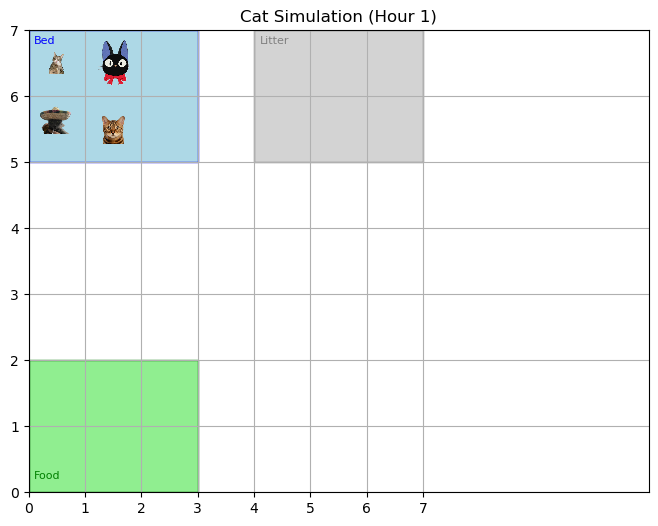

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
import random
from PIL import Image
from IPython.display import HTML

# Grid size
grid_size = 7
frame_counter = 0
steps_per_hour = 10   # number of frames per hour
total_hours = 12
total_frames = steps_per_hour * total_hours

# Define zones for 7x7 grid
zones = {
    "bed": [(x, y) for x in range(0, 3) for y in range(5, 7)],
    "food": [(x, y) for x in range(0, 3) for y in range(0, 2)],
    "litter": [(x, y) for x in range(4, 7) for y in range(5, 7)],
    # "roam" zone is anywhere not in the other 
    # and not in the litter box, bed or food zone
    "roam": [(x, y) for x in range(grid_size) for y in range(grid_size) 
             if (x, y) not in [(x, y) for x in range(0, 3) for y in range(5, 7)] and
                (x, y) not in [(x, y) for x in range(0, 3) for y in range(0, 2)] and
                (x, y) not in [(x, y) for x in range(4, 7) for y in range(5, 7)]]
}

# Cat data
cats = {
    "Tito": {
        "position": [0, 5],
        "image": "tito.png",
        "goal": "bed",
        "personality": {'Playful': 2, 'Shy': 1, 'Calm': 1, 'Aggressive': 1},
        "play_count": 0,
        "fight_count": 0,
        "interaction_count": 0,
        "last_interaction_hour": 0,
        "original_goal": "bed",
        "fed": False,
        "used_litter": False,  # Track if cat used litter after eating
        "roam_timer": 0,       # Timer for roaming behavior
        "roam_target": None    # Target position when roaming
    },
    "Tobi": {
        "position": [1, 5],
        "image": "tobi.png",
        "goal": "food",
        "personality": {'Playful': 1, 'Shy': 2, 'Calm': 1, 'Aggressive': 1},
        "play_count": 0,
        "fight_count": 0,
        "interaction_count": 0,
        "last_interaction_hour": 0,
        "original_goal": "food",
        "fed": False,
        "used_litter": False,
        "roam_timer": 0,
        "roam_target": None
    },
    "Dumpling": {
        "position": [0, 6],
        "image": "dumpling.png",
        "goal": "litter",
        "personality": {'Playful': 1, 'Shy': 1, 'Calm': 2, 'Aggressive': 1},
        "play_count": 0,
        "fight_count": 0,
        "interaction_count": 0,
        "last_interaction_hour": 0,
        "original_goal": "litter",
        "fed": False,
        "used_litter": False,
        "roam_timer": 0,
        "roam_target": None
    },
    "Jiji": {
        "position": [1, 6],
        "image": "jiji.png",
        "goal": "bed",
        "personality": {'Playful': 1, 'Shy': 1, 'Calm': 1, 'Aggressive': 2},
        "play_count": 0,
        "fight_count": 0,
        "interaction_count": 0,
        "last_interaction_hour": 0,
        "original_goal": "bed",
        "fed": False,
        "used_litter": False,
        "roam_timer": 0,
        "roam_target": None
    }
}

# Setup plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(0, grid_size+4)
ax.set_ylim(0, grid_size)
ax.set_xticks(np.arange(0, grid_size+1, 1))
ax.set_yticks(np.arange(0, grid_size+1, 1))
ax.grid(True)
title_text = ax.set_title("Cat Simulation (Hour 1)")

# Draw zones
ax.add_patch(patches.Rectangle((0, 5), 3, 2, edgecolor='blue', facecolor='lightblue'))  # Bed
ax.text(0.1, 6.8, "Bed", fontsize=8, color='blue')

ax.add_patch(patches.Rectangle((4, 5), 3, 2, edgecolor='gray', facecolor='lightgray'))  # Litter
ax.text(4.1, 6.8, "Litter", fontsize=8, color='gray')

ax.add_patch(patches.Rectangle((0, 0), 3, 2, edgecolor='green', facecolor='lightgreen'))  # Food
ax.text(0.1, 0.2, "Food", fontsize=8, color='green')

# Load and draw cats
cat_artists = {}
play_markers = []
fight_markers = []
goal_change_texts = []  # To display goal change notifications
status_icons = {}  # To display status icons for cats

def load_cat_image(path, zoom=0.15):
    image = Image.open(path)
    return OffsetImage(image, zoom=zoom)

for name, info in cats.items():
    img = load_cat_image(info["image"])
    ab = AnnotationBbox(img, (info["position"][0] + 0.5, info["position"][1] + 0.5), frameon=False)
    cat_artists[name] = ab
    ax.add_artist(ab)

def are_adjacent(pos1, pos2):
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1]) == 1

def can_play(cat1, cat2):
    if cat1["personality"].get("Aggressive", 0) >= 2 or cat2["personality"].get("Aggressive", 0) >= 2:
        return False
    if cat1["personality"].get("Playful", 0) >= 2 and cat2["personality"].get("Playful", 0) >= 2:
        return True
    if cat1["personality"].get("Playful", 0) >= 2 and cat2["personality"].get("Calm", 0) >= 2:
        return True
    if cat2["personality"].get("Playful", 0) >= 2 and cat1["personality"].get("Calm", 0) >= 2:
        return True
    return False

def will_fight(cat1, cat2):
    a1 = cat1["personality"].get("Aggressive", 0)
    a2 = cat2["personality"].get("Aggressive", 0)
    p1 = cat1["personality"].get("Playful", 0)
    p2 = cat2["personality"].get("Playful", 0)
    return (a1 >= 2 or a2 >= 2) or (p1 >= 2 and a2 >= 2) or (p2 >= 2 and a1 >= 2)

def show_play_marker(pos1, pos2):
    x = (pos1[0] + pos2[0]) / 2 + 0.5
    y = (pos1[1] + pos2[1]) / 2 + 0.5
    marker = ax.plot(x, y, 'ro', markersize=6)[0]
    play_markers.append(marker)

def show_fight_marker(pos1, pos2):
    x = (pos1[0] + pos2[0]) / 2 + 0.5
    y = (pos1[1] + pos2[1]) / 2 + 0.5
    marker = ax.text(x, y, 'X', color='red', fontsize=14, weight='bold', ha='center', va='center')
    fight_markers.append(marker)

def show_goal_change_text(name, pos, new_goal, reason):
    label_x = grid_size + 0.3
    label_y = grid_size - (len(goal_change_texts) % grid_size) - 0.5
    text = ax.text(label_x, label_y, f"{name} → {new_goal} ({reason})",
                   color='purple', fontsize=8, ha='left', va='center',
                   bbox=dict(facecolor='white', alpha=0.7))
    goal_change_texts.append((text, frame_counter + 20))  # show for 20 frames

def get_neighbors(pos, exclude_name):
    return [info["position"] for name, info in cats.items()
            if name != exclude_name and are_adjacent(pos, info["position"])]

def is_in_zone(position, zone_name):
    return tuple(position) in zones[zone_name]

def update_cat_goal(name, info, current_hour):
    x, y = info["position"]
    
    # Check if cat is in target zones
    is_in_food_zone = is_in_zone(info["position"], "food")
    is_in_litter_zone = is_in_zone(info["position"], "litter")
    is_in_bed_zone = is_in_zone(info["position"], "bed")
    
    # Process after eating logic
    if info["goal"] == "food" and is_in_food_zone and not info["fed"]:
        # Reset interaction counts after eating
        info["interaction_count"] = 0
        info["last_interaction_hour"] = current_hour
        info["fed"] = True
        info["used_litter"] = False
        
        # Go to litter box after eating
        info["goal"] = "litter"
        show_goal_change_text(name, info["position"], "litter", "after eating")
        return True
    
    # Process after using litter box
    elif info["goal"] == "litter" and is_in_litter_zone and info["fed"] and not info["used_litter"]:
        info["used_litter"] = True
        
        # After using litter, decide whether to roam or go back to original goal
        if random.random() < 0.7:  # 70% chance to start roaming after using litter
            info["goal"] = "roam"
            info["roam_timer"] = random.randint(20, 40)  # Roam for 20-40 frames
            info["roam_target"] = random.choice(zones["roam"])
            show_goal_change_text(name, info["position"], "roam", "after litter")
        else:
            info["goal"] = info["original_goal"]
            show_goal_change_text(name, info["position"], info["original_goal"], "after litter")
            
            # Remove status icon if exists
            if name in status_icons:
                status_icons[name].remove()
                del status_icons[name]
        return True
    
    # Check if cat is in bed zone and has been there for a while
    elif info["goal"] == "bed" and is_in_bed_zone:
        # 10% chance per frame to start roaming from bed if fed and used litter
        if info["fed"] and info["used_litter"] and random.random() < 0.1:
            info["goal"] = "roam"
            info["roam_timer"] = random.randint(30, 50)  # Roam for longer from bed
            info["roam_target"] = random.choice(zones["roam"])
            show_goal_change_text(name, info["position"], "roam", "from bed")
            return True
    
    # Check if the cat needs to change goal to food after 3 interactions
    elif info["interaction_count"] >= 3 and info["goal"] != "food":
        info["goal"] = "food"
        info["fed"] = False
        info["used_litter"] = False
        show_goal_change_text(name, info["position"], "food", "3+ interactions")
        return True
    
    # Check if cat hasn't interacted for 3+ hours
    elif current_hour >= 4:  # After sleeping hours
        hours_without_interaction = current_hour - info["last_interaction_hour"]
        if hours_without_interaction >= 3 and info["goal"] != "food" and info["last_interaction_hour"] > 0:
            info["goal"] = "food"
            info["fed"] = False
            info["used_litter"] = False
            show_goal_change_text(name, info["position"], "food", "no interaction")
            return True
    
    # Handle roaming behavior
    if info["goal"] == "roam":
        # Decrease roam timer
        info["roam_timer"] -= 1
        
        # If reached the target or timer expired, stop roaming
        if info["roam_timer"] <= 0 or (info["position"][0], info["position"][1]) == info["roam_target"]:
            # After roaming, go back to original goal
            info["goal"] = info["original_goal"]
            info["roam_target"] = None
            show_goal_change_text(name, info["position"], info["original_goal"], "done roaming")
            
            # Remove roam icon
            if name in status_icons:
                status_icons[name].remove()
                del status_icons[name]
            return True
        
        # Occasionally pick a new roaming target
        elif random.random() < 0.05:  # 5% chance to change target
            info["roam_target"] = random.choice(zones["roam"])
            return True
    
    # Randomly decide to roam if not doing anything important
    elif random.random() < 0.01 and info["goal"] not in ["food", "litter"] and info["fed"] and info["used_litter"]:
        info["goal"] = "roam"
        info["roam_timer"] = random.randint(20, 40)
        info["roam_target"] = random.choice(zones["roam"])
        show_goal_change_text(name, info["position"], "roam", "random")
        return True
        
    return False

def move_cat(name, info, current_hour):
    x, y = info["position"]
    
    # Update the cat's goal if needed
    update_cat_goal(name, info, current_hour)
    
    shy = info["personality"].get("Shy", 0) >= 2
    neighbors = get_neighbors(info["position"], name)
    
    # Shy cats avoid others
    if shy and neighbors:
        dx = x - neighbors[0][0]
        dy = y - neighbors[0][1]
        if dx != 0 and 0 <= x + np.sign(dx) < grid_size:
            return [x + np.sign(dx), y]
        if dy != 0 and 0 <= y + np.sign(dy) < grid_size:
            return [x, y + np.sign(dy)]
    
    # ROAMING BEHAVIOR
    if info["goal"] == "roam" and info["roam_target"]:
        target_x, target_y = info["roam_target"]
        dx = target_x - x
        dy = target_y - y
        
        # Add some randomness to roaming (30% chance to move randomly)
        if random.random() < 0.3:
            possible_moves = []
            for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
                new_x, new_y = x + dx, y + dy
                if 0 <= new_x < grid_size and 0 <= new_y < grid_size:
                    possible_moves.append([new_x, new_y])
            
            if possible_moves:
                return random.choice(possible_moves)
        
        # Otherwise move toward target
        if abs(dx) > abs(dy):
            new_x = x + np.sign(dx)
            if 0 <= new_x < grid_size:
                return [new_x, y]
        elif dy != 0:
            new_y = y + np.sign(dy)
            if 0 <= new_y < grid_size:
                return [x, new_y]
    
    # GOAL-DIRECTED BEHAVIOR (bed, food, litter)
    else:
        goal_zone = zones[info["goal"]]
        closest = min(goal_zone, key=lambda g: abs(g[0] - x) + abs(g[1] - y))
        dx = closest[0] - x
        dy = closest[1] - y
        
        if abs(dx) > abs(dy):
            new_x = x + np.sign(dx)
            if 0 <= new_x < grid_size:
                return [new_x, y]
        elif dy != 0:
            new_y = y + np.sign(dy)
            if 0 <= new_y < grid_size:
                return [x, new_y]
    
    # If can't move toward goal, try a random valid move
    return random.choice([
        [x + 1, y] if x + 1 < grid_size else [x, y],
        [x - 1, y] if x - 1 >= 0 else [x, y],
        [x, y + 1] if y + 1 < grid_size else [x, y],
        [x, y - 1] if y - 1 >= 0 else [x, y]
    ])

def update(frame):
    global frame_counter
    frame_counter += 1

    current_hour = frame // steps_per_hour + 1
    if current_hour <= total_hours:
        title_text.set_text(f"Cat Simulation (Hour {current_hour})")

    # Remove expired goal change texts
    for i in range(len(goal_change_texts) - 1, -1, -1):
        text, expiry_frame = goal_change_texts[i]
        if frame_counter >= expiry_frame:
            text.remove()
            goal_change_texts.pop(i)

    # Cats sleep during hours 1 and 2
    if current_hour in [1, 2]:
        return list(cat_artists.values()) + [text for text, _ in goal_change_texts]

    for marker in play_markers:
        marker.remove()
    play_markers.clear()
    for marker in fight_markers:
        marker.remove()
    fight_markers.clear()

    # Track which cats interacted this frame
    interacted_cats = set()

    for name, info in cats.items():
        # Only move after initial frames
        if frame_counter >= 10:
            info["position"] = move_cat(name, info, current_hour)
            cat_artists[name].xybox = (info["position"][0] + 0.5, info["position"][1] + 0.5)

    interacted_pairs = set()
    for name1, info1 in cats.items():
        for name2, info2 in cats.items():
            if name1 == name2:
                continue
            pair = tuple(sorted((name1, name2)))
            if pair in interacted_pairs:
                continue
            if are_adjacent(info1["position"], info2["position"]):
                interaction_occurred = False
                
                if can_play(info1, info2):
                    show_play_marker(info1["position"], info2["position"])
                    cats[name1]["play_count"] += 1
                    cats[name2]["play_count"] += 1
                    interaction_occurred = True
                elif will_fight(info1, info2):
                    show_fight_marker(info1["position"], info2["position"])
                    cats[name1]["fight_count"] += 1
                    cats[name2]["fight_count"] += 1
                    interaction_occurred = True
                    
                if interaction_occurred:
                    cats[name1]["interaction_count"] += 1
                    cats[name2]["interaction_count"] += 1
                    cats[name1]["last_interaction_hour"] = current_hour
                    cats[name2]["last_interaction_hour"] = current_hour
                    interacted_cats.add(name1)
                    interacted_cats.add(name2)
                    
                interacted_pairs.add(pair)

    return list(cat_artists.values()) + play_markers + fight_markers + [text for text, _ in goal_change_texts]

def print_final_stats():
    print("Final Interaction Counts:")
    for name, info in cats.items():
        print(f"{name}: Plays = {info['play_count']}, Fights = {info['fight_count']}, Total = {info['play_count'] + info['fight_count']}")

anim = animation.FuncAnimation(fig, update, frames=total_frames, interval=500, blit=True)
plt.show()
HTML(anim.to_jshtml())

In [549]:
print_final_stats()

Final Interaction Counts:
Tito: Plays = 1, Fights = 23, Total = 24
Tobi: Plays = 0, Fights = 8, Total = 8
Dumpling: Plays = 1, Fights = 57, Total = 58
Jiji: Plays = 0, Fights = 88, Total = 88
